In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import seaborn as sns
from feature_engine.imputation import MeanMedianImputer,CategoricalImputer 
from sklearn.pipeline import Pipeline
import scipy.stats as stat
import pylab
from feature_engine.encoding import OneHotEncoder,RareLabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
#from sklearn.metrics import roc_auc_scorex
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, confusion_matrix, f1_score, precision_recall_curve, roc_curve, plot_roc_curve, plot_precision_recall_curve 
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [ ]:
! pip install feature_engine

In [ ]:
! pip install  feature_engine

In [ ]:
! pip install mlxtend

In [6]:
def read_data():
  df_emp=pd.read_csv("/content/employee_promotion[1].csv")
  return df_emp  

# Categorize Numerical and Categorical Variable

In [7]:
def categ_features():
  num_features=[i for i in df_emp.columns if df_emp.dtypes[i]!='object']
  cat_features=[i for i in df_emp.columns if df_emp.dtypes[i]=='object']
  return num_features,cat_features  

# Plot Distribution of Features

# Using Pieplot

In [8]:
def plot_distribution(df_emp):
  fig, axs = plt.subplots(nrows=6, ncols=5, figsize=(40, 20))

  for i, feature in enumerate(df_emp.columns):
      row = int(i/4)
      col = i%4
      pd.value_counts(df_emp.iloc[:, i]).plot.pie(autopct="%.1f%%", ax=axs[row][col])

  plt.suptitle('Distribution of features Before Imputation')
  plt.tight_layout()

# Using Barplot for numerical features

In [9]:
def plot_dist_num_features(num_features):
 for i in num_features:
    plt.figsize=(10,5)
    sns.boxplot(y=df_emp[i])
    plt.show()

## Get Features Containing Missing Values

In [10]:
def get_miss_features():
   ls=df_emp.isnull().mean()>0
   mask=ls.values==True
   ls=list(ls[mask].index)
   return ls

# Using probplot

In [11]:
def plot_curve(df,feature):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.show()

# Drop Features

In [12]:
def drop_features():
  df_emp.drop(columns=['employee_id'], inplace=True)

# Missing Value Imputation

In [13]:
def miss_impute(num_features,cat_features):
    pipe = Pipeline(
    [
        (
            "median_imputer",
            MeanMedianImputer(
                imputation_method="median", variables=num_features
            ),
        ),
        ("imputer_missing", CategoricalImputer(variables=cat_features)),
       
    ]
)
    df_emp_t=pipe.fit_transform(df_emp)
    return df_emp_t

# Categorical Feature Encoding

In [14]:
def encode_cat(df):
  encoder = OneHotEncoder(
      variables=['department','education','gender', 'recruitment_channel'],  # alternatively pass a list of variables
      drop_last=True,  # to return k-1, use drop=false to return k dummies
  )
  df_emp_e = encoder.fit_transform(df)
  
  return df_emp_e

In [15]:
def encode_rare(lst_feat,df):
  rare_encoder = RareLabelEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=4,  # minimal number of categories the variable should have to re-cgroup rare categories
    variables=['region'],  # variables to re-group
)
  df_emp_r=rare_encoder.fit_transform(df)
  return df_emp_r

In [16]:
def encode_cat_rare(df):
  encoder = OneHotEncoder(
      variables=['region'],  # alternatively pass a list of variables
      drop_last=True,  # to return k-1, use drop=false to return k dummies
  )
  df_emp_s = encoder.fit_transform(df)
  return df_emp_s

# Normalization /Standardization

In [17]:
def standardize(df):
  scaler = StandardScaler()
  # fit the scaler to the train set, it will learn the parameters
  df_emp_t=scaler.fit_transform(df)
  df_emp_t=np.round(df_emp_t, 1)
  df_emp_t = pd.DataFrame(df_emp_t, columns=df.columns)
  return df_emp_t
  

# Split

In [18]:
def split(df):
  x = df.drop(columns=['is_promoted'], inplace=False)
  y = df['is_promoted'].astype(int)
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=11)
  return X_train, X_test, y_train, y_test

## Feature Selection

### Remove Correlated Features

In [19]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [20]:
def forward_selection_features(X_train,y_train,num):
   sfs = SFS(RandomForestClassifier(n_estimators=10, n_jobs=4, random_state=0), 
           k_features=num, # the more features we want, the longer it will take to run
           forward=True, 
           floating=False, # see the docs for more details in this parameter
           verbose=2, # this indicates how much to print out intermediate steps
           scoring='roc_auc',
           cv=5,
         )

   sfs = sfs.fit(X_train, y_train)
   selected_feat = X_train.columns[list(sfs.k_feature_idx_)]
   return selected_feat

Compare performance of feature subsets

In [21]:
def run_randomForests(X_train, X_test, y_train, y_test):
    
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

# Model Development:
## #We will use the following models in this project:
#Decison Tree Classifier
#Random Forest Classifer
#Logistic Regression

In [54]:
def log_regression(X_train,y_train,X_test):
# Create Objcet 
  lr_clf = LogisticRegression()
  # Fit the X_train,y_train
  lr_clf.fit(X_train, y_train)
  # Predict based on X_test
  lr_pred = lr_clf.predict(X_test)

  lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]
  return lr_pred,lr_pred_proba,lr_clf

# Performance metrix

In [28]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="macro")
    recall = recall_score(y_test, pred, average="macro")
    f1 = f1_score(y_test, pred, average="macro")
    roc_auc = roc_auc_score(y_test, pred_proba, average="macro")
    print('Confusion Matrix')
    print(confusion)
    print('Accuracy: {0:.4f}, Precision: {1:.4f}, Recall {2:.4f}, F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

# HyperParameter Tuning

In [30]:
df_emp=read_data()

In [31]:
drop_features()

In [32]:
num_features,cat_features =categ_features()

In [33]:
ls_miss=get_miss_features()

In [34]:
df_emp_t=miss_impute(['previous_year_rating', 'avg_training_score'],['education'])

In [ ]:
plot_dist_num_features(num_features)

In [ ]:
plot_distribution(df_emp_t)

In [37]:
df_emp_e=encode_cat(df_emp_t)

In [38]:
df_emp_r=encode_rare(['region'],df_emp_e)

In [39]:
df_emp_s=encode_cat_rare(df_emp_r)

In [40]:
df_emp_t=standardize(df_emp_s)

In [41]:
corr_features = correlation(df_emp_t, 0.8)
print('correlated features: ', len(set(corr_features)) )
corr_features

correlated features:  2


{"education_Bachelor's", 'recruitment_channel_other'}

In [42]:
df_emp_t.drop(labels=corr_features, axis=1, inplace=True)

In [ ]:
df_emp_t.shape

(54808, 23)

In [ ]:
df_emp_t.describe().T


In [43]:
X_train, X_test, y_train, y_test=split(df_emp_t)

In [ ]:
selected_feat=forward_selection_features(X_train,y_train,10)
selected_feat

In [45]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.7678131783019532
Test set
Random Forests roc-auc: 0.7568481045917639


In [46]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.77267612953757
Test set
Random Forests roc-auc: 0.7550938481090242


In [55]:
lr_pred,lr_pred_proba,lr_clf=log_regression(X_train,y_train,X_test)

In [56]:
get_clf_eval(y_test, lr_pred, lr_pred_proba)

Confusion Matrix
[[9975   16]
 [ 710  261]]
Accuracy: 0.9338, Precision: 0.9379, Recall 0.6336, F1: 0.6916, AUC:0.7820


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


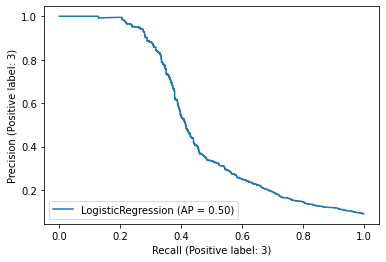

In [57]:
plot_precision_recall_curve(lr_clf, X_test, y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


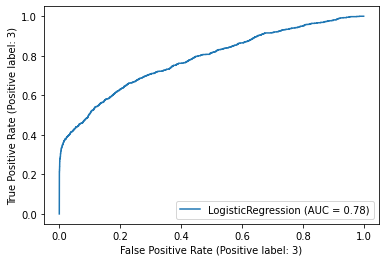

In [58]:
plot_roc_curve(lr_clf, X_test, y_test)